Contents of this ipython notebook:
    1. Import statements
    2. Read csv datafile into a pandas dataframe.
    3. Do exploratory data analysis.
    4. Use natural language processing algorithms to predict whether a review is deceptive or truthful
        A. Term Frequency-Inverse Document Frequency
        B. Topic Analysis          
    5. Which algorithm produces the best results?
   
    http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/

1. Import Libraries

In [1]:
import pandas
import numpy
import spacy
%matplotlib inline
from scipy.stats import ttest_ind
import nltk
from nltk.corpus import stopwords
import re
import en_core_web_md
import gensim
#install gensim
from collections import defaultdict
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifierlda
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
#from sklearn.lda import LDA 
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

C:\Users\Karen\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Karen\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


2. Read csv datafile into a pandas dataframe.

In [2]:
reviewsdf = pandas.read_csv('deceptive-opinion.csv')

3. Exploratory Data Analysis

In [3]:
reviewsdf.tail(5)

,deceptive,hotel,polarity,source,text
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama..."


In [4]:
reviewsdf.pivot_table(
    columns=['deceptive','polarity'],
    values=['deceptive','polarity'],
    index = ['hotel'],
    aggfunc = len).fillna(0)

source                                 text           \
deceptive        deceptive          truthful          deceptive            
polarity          negative positive negative positive  negative positive   
hotel                                                                      
affinia                 20       20       20       20        20       20   
allegro                 20       20       20       20        20       20   
amalfi                  20       20       20       20        20       20   
ambassador              20       20       20       20        20       20   
conrad                  20       20       20       20        20       20   
fairmont                20       20       20       20        20       20   
hardrock                20       20       20       20        20       20   
hilton                  20       20       20       20        20       20   
homewood                20       20       20       20        20       20   
hyatt                   20       20       20       20        20       20   
intercontinental        20       20       20       20        20       20   
james                   20       20       20       20        20       20   
knickerbocker           20       20       20       20        20       20   
monaco                  20       20       20       20        20       20   
omni                    20       20       20       20        20       20   
palmer                  20       20       20       20        20       20   
sheraton                20       20       20       20        20       20   
sofitel                 20       20       20       20        20       20   
swissotel               20       20       20       20        20       20   
talbott                 20       20       20       20        20       20   

                                    
deceptive        truthful           
polarity         negative positive  
hotel                               
affinia                20       20  
allegro                20       20  
amalfi                 20       20  
ambassador             20       20  
conrad                 20       20  
fairmont               20       20  
hardrock               20       20  
hilton                 20       20  
homewood               20       20  
hyatt                  20       20  
intercontinental       20       20  
james                  20       20  
knickerbocker          20       20  
monaco                 20       20  
omni                   20       20  
palmer                 20       20  
sheraton               20       20  
sofitel                20       20  
swissotel              20       20  
talbott                20       20

Determine Average Word Length to see if it differs between truthful and deceptive reviews.
The results show that the average word length is fairly consistent between truthful and deceptive reviews, but it varies significantly between negative and positive reviews.

In [5]:
#Mean Length Functon
def mean_len(group, mean = True):
    if mean == True:
        return numpy.mean(group.text.str.len())
    else:
        return group.text.str.len()

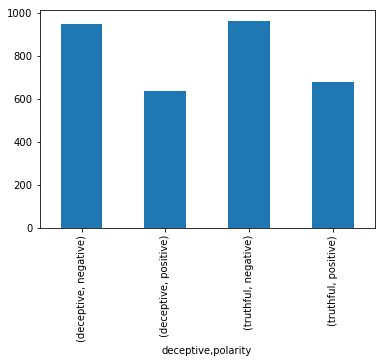

In [6]:
plotvar = reviewsdf.groupby(
    ['deceptive','polarity']).apply(
    mean_len, mean = True).plot('bar')

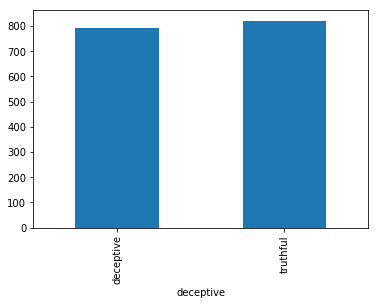

In [7]:
plotvar2 = reviewsdf.groupby(
    ['deceptive']).apply(
    mean_len, mean = True).plot('bar')

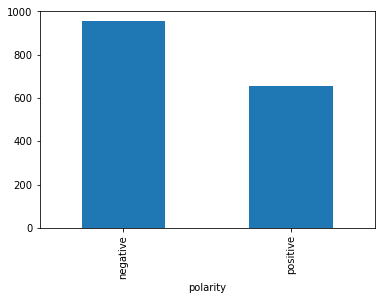

In [8]:
plotvar3 = reviewsdf.groupby(
    ['polarity']).apply(
    mean_len, mean = True).plot('bar')

In [9]:
#Ttest results
pandas.set_option('display.float_format',lambda x: '%2f' %x)
testpolarity= ttest_ind(
    reviewsdf[reviewsdf.polarity=='positive'].text.str.len(),
    reviewsdf[reviewsdf.polarity=='negative'].text.str.len())


testdeceptive= ttest_ind(
    reviewsdf[reviewsdf.deceptive=='deceptive'].text.str.len(),
    reviewsdf[reviewsdf.deceptive=='truthful'].text.str.len())

testpolarity, testdeceptive

(Ttest_indResult(statistic=-13.519240422712002, pvalue=1.6379745425467699e-39),
 Ttest_indResult(statistic=-1.2660429409833915, pvalue=0.20568224165031751))

Ttest results show that there is a statistically significant difference between positive and negative
mean length of words, but not between deceptive and truthful mean length of words.

make a copy of the df for nlp 

In [10]:
nlpcopy=reviewsdf.copy()
nlpcopy.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


Stopwords
http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb

4. Use natural language processing algorithms to predict whether a review is deceptive or truthful 

4A. Term Frequency-Inverse Document Frequency



4B. Topic Analysis

In [11]:
stopwds=set(stopwords.words('english'))

https://stackoverflow.com/questions/43071775/spacy-how-to-get-the-spacy-model-name
Note that models are not downloaded automatically when you install spaCy, so you have to download them separately (see the docs for a list of available models):

python -m spacy download en              # default English model (~50MB)
python -m spacy download en_core_web_md  # larger English model (~1GB)
c:\users\karen\Anaconda3\Lib\site-packages

In [12]:
nlp=en_core_web_md.load()

In [13]:
parsed = nlp.pipe(iter(nlpcopy['text']),batch_size=1,n_threads=4)

tokens,lemma,parts,stopword=[],[],[],[]

for parsed_review in parsed:
    tokens.append([n.text for n in parsed_review])
    lemma.append([n.lemma_ for n in parsed_review])
    parts.append([n.pos_ for n in parsed_review])
    stopword.append([n.is_stop for n in parsed_review])
nlpcopy['tokens'] = tokens 
nlpcopy['tokens_stopwords'] = nlpcopy['tokens'].apply(lambda x: [item for item in x if item not in stopwds])
nlpcopy['lemma'] = lemma
nlpcopy['pos'] = parts
nlpcopy['stopword'] = stopword
nlpcopy.head(4)

,deceptive,hotel,polarity,source,text,tokens,tokens_stopwords,lemma,pos,stopword
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,"[We, stayed, for, a, one, night, getaway, with...","[We, stayed, one, night, getaway, family, thur...","[-PRON-, stay, for, a, one, night, getaway, wi...","[PRON, VERB, ADP, DET, NUM, NOUN, NOUN, ADP, N...","[False, False, False, False, False, False, Fal..."
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,"[Triple, A, rate, with, upgrade, to, view, roo...","[Triple, A, rate, upgrade, view, room, less, $...","[triple, a, rate, with, upgrade, to, view, roo...","[ADJ, DET, NOUN, ADP, NOUN, PART, NOUN, NOUN, ...","[False, False, False, False, False, False, Fal..."
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,"[This, comes, a, little, late, as, I, 'm, fina...","[This, comes, little, late, I, 'm, finally, ca...","[this, come, a, little, late, as, -PRON-, be, ...","[DET, VERB, DET, ADJ, ADJ, ADP, PRON, VERB, AD...","[False, False, False, False, False, False, Fal..."
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[The, Omni, Chicago, really, delivers, on, all...","[The, Omni, Chicago, really, delivers, fronts,...","[the, omni, chicago, really, deliver, on, all,...","[DET, PROPN, PROPN, ADV, VERB, ADP, DET, NOUN,...","[False, False, False, False, False, False, Fal..."


In [14]:
pron_ct = []
noun_ct = []
punct_ct = []
verb_ct = []

for row in nlpcopy.pos:
    pron_ct.append(sum([i == 'PRON'  for i in row]))
    noun_ct.append(sum([i == 'NOUN'  for i in row]))
    punct_ct.append(sum([i == 'PUNCT'  for i in row]))
    verb_ct.append(sum([i == 'VERB'  for i in row]))

# count stopwords
stop_row = []
for row in nlpcopy.stopword:
    stop_row.append(sum(row))
    
# count POS
nlpcopy['pron_ct'] = pron_ct
nlpcopy['noun_ct'] = noun_ct
nlpcopy['punct_ct'] = punct_ct
nlpcopy['verb_ct'] = verb_ct
nlpcopy['stoprow'] = stop_row
# results
nlpcopy.head(2)

,deceptive,hotel,polarity,source,text,tokens,tokens_stopwords,lemma,pos,stopword,pron_ct,noun_ct,punct_ct,verb_ct,stoprow
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,"[We, stayed, for, a, one, night, getaway, with...","[We, stayed, one, night, getaway, family, thur...","[-PRON-, stay, for, a, one, night, getaway, wi...","[PRON, VERB, ADP, DET, NUM, NOUN, NOUN, ADP, N...","[False, False, False, False, False, False, Fal...",5,30,12,14,0
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,"[Triple, A, rate, with, upgrade, to, view, roo...","[Triple, A, rate, upgrade, view, room, less, $...","[triple, a, rate, with, upgrade, to, view, roo...","[ADJ, DET, NOUN, ADP, NOUN, PART, NOUN, NOUN, ...","[False, False, False, False, False, False, Fal...",0,14,9,4,0


In [15]:
# perform topic analysis on reveiws

def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gensim.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gensim.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Reduce into 100 topics.
    topic_n = topic_n
    lsi = gensim.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi  

train_data = nlpcopy.tokens_stopwords
topic_n = 100

built = build_model(
    train_data = train_data,
    topic_n = 100)

In [16]:
nlpcopysvd = pandas.DataFrame([dict(row) for row in built[0]])
topicsfromtext = nlpcopysvd

In [17]:
# Topic Analysis
#http://journalofdigitalhumanities.org/2-1/topic-modeling-a-basic-introduction-by-megan-r-brett/
X1 = topicsfromtext
Y = nlpcopy.deceptive == 'deceptive'

In [18]:
seed = 6
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('LSVM', LinearSVC()))
models.append(('RF', RandomForestClassifier(n_jobs = -1, n_estimators = 500)))

In [19]:
models.append(('LDA', LinearDiscriminantAnalysis()))

In [20]:
def run_models(train_data, title):
    results = []
    names = []
    resmean = []
    resstd = []
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, train_data, Y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        resmean.append(cv_results.mean())
        resstd.append(cv_results.std())
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)


    # bar algorithm comparison
    N=6
    ind=numpy.arange(N)
    width = .85
    #fig = pyplot.figure()
    #fig.suptitle(title)
    fig, ax = pyplot.subplots()
    rects = ax.bar(ind, resmean, width, color='b', yerr=resstd)
    ax.set_xticklabels(('LR','LR', 'NB', 'SVM','LSVM', 'RF', 'LDA'))
    pyplot.ylim(0,1)
    pyplot.show()

5. Which algorithm produces the best results?

In [21]:
X1.shape

(1600, 100)

LR: 0.763750 (0.077752)
NB: 0.710000 (0.137789)
SVM: 0.173750 (0.347545)
LSVM: 0.825625 (0.045195)
RF: 0.776250 (0.057269)
LDA: 0.836250 (0.041345)


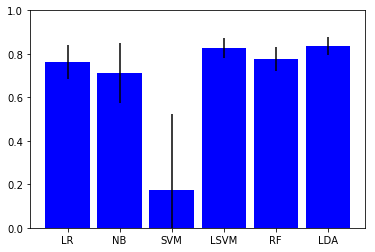

In [22]:
run_models(X1, title= 'Algorithm Comparison')

Linear Discriminant Analysis predicts the results with an 84% accuracy.